In [3]:
import sqlalchemy
import pandas as pd
import numpy as np

## MVP

In [4]:
# from sqlalchemy import create_engine
# engine = create_engine('postgresql:///walk')

In [5]:
df = pd.read_sql_table('manhattan_loc_d_ar_wea', 'postgresql:///walk')

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
def categorize_arrests(dataframe):
    cat_df = pd.DataFrame(dataframe, columns=['n_arrests'])
    cat_df.loc[cat_df['n_arrests'] > 0] = 1
    cat_df = cat_df.fillna(value=0).astype(int)
    output = cat_df.values.ravel()
    return output

In [37]:
last_ten = df.shape[0]*.9
eval_df = df.reset_index(drop=True).loc[last_ten:]
test_train_df = df.reset_index(drop=True).loc[:last_ten]
X_eval = eval_df.drop(columns=['n_arrests'])
y_eval = categorize_arrests(eval_df['n_arrests'])

In [38]:
X = test_train_df.drop(columns=['n_arrests'])
y = categorize_arrests(test_train_df['n_arrests'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [50]:
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import time

In [10]:
class DateTransformer():
    """Transforms df so that there are columns representing the features of the date.
    """
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.Series([pd.to_datetime(x, format="%Y-%m-%d") for x in X['date']])
        X_transf = pd.DataFrame()
        X_transf['year'] = [x.year for x in X]
        X_transf['month'] = [x.month for x in X]
        X_transf['day'] = [x.day for x in X]
        X_transf['weekday'] = [x.weekday() for x in X]
        return np.array(X_transf)

In [11]:
class TimeOfDayTransformer():    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        structtime = [time.gmtime(x) for x in X.values]
        X_transf = np.array([(x.tm_hour*60 + x.tm_min) for x in structtime]).reshape(-1, 1)
        return X_transf

In [12]:
class StringTransformer():    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
#         X_trans = np.array(X.astype(str)).reshape(-1, 1)
#         print(X_trans)
        return np.array(X.astype(str)).reshape(-1, 2)

In [13]:
impute_zero_features = ['precip_accum100']
impute_zero_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

impute_mean_features = ['ozone10']
impute_mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

date_transformer = Pipeline(steps=[
    ('date_expansion', DateTransformer()),
    ('ohe', OneHotEncoder(categories='auto'))
])

categorical_features = ['icon', 'precipType']
categorical_transformer = Pipeline(steps=[
    ('string', StringTransformer()),
    ('ohe', OneHotEncoder(categories='auto'))
])

time_of_day_features = ['sunriseTime', 'sunsetTime']
time_of_day_transformer = Pipeline(steps=[
    ('time', TimeOfDayTransformer()),
    ('scaler', StandardScaler())
])

other_numeric_features = ['latitude', 'longitude', 'ap_t_high100',
                         'ap_t_low100', 'cloud', 'humidity', 'moon_phase',
                          'precip_inten_max10000', 'precip_proba100', 'pressure',
                         'uvIndex', 'wind_gust100',]

preprocessor = ColumnTransformer( transformers=[
    ('missing0', impute_zero_transformer, impute_zero_features),
    ('missing_mean', impute_mean_transformer, impute_mean_features),
    ('date', date_transformer, ['date']),
    ('categoricals', categorical_transformer, categorical_features),
    ('sunrise', time_of_day_transformer, ['sunriseTime']),
    ('sunset', time_of_day_transformer, ['sunsetTime']),
    ('ss', StandardScaler(), other_numeric_features)
    ], remainder='passthrough')




In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import log_loss
from imblearn.over_sampling import SMOTE

In [47]:
rfc = RandomForestClassifier()
sm = SMOTE(random_state=20)

In [53]:
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('smote', sm),
    ('model', rfc)
])

In [54]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 10:41:54


In [55]:
# ~30 min runtime
pipe.fit(X_train, y_train)

//anaconda3/envs/walk-env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('missing0',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=0,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                    

In [56]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 15:25:34


In [64]:
train_preds = pipe.predict(X_train)
train_proba = pipe.predict_proba(X_train)

In [65]:
def print_scores(true, pred, pred_proba):
    lloss = log_loss(true, pred_proba)
    cf = confusion_matrix(true, pred)
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred)
    print(f"log loss: {lloss}\n\nconfusion matrix:\n{cf}\naccuracy: {acc}\nF1 score: {f1}")

In [66]:
print_scores(y_train, train_preds, train_proba)

log loss: 0.03984980781059711

confusion matrix:
[[2430491    2443]
 [   3481   40414]]
accuracy: 0.9976082321387548
F1 score: 0.9317133898930284


In [67]:
test_preds = pipe.predict(X_test)
test_proba = pipe.predict_proba(X_test)

In [68]:
print_scores(y_test, test_preds, test_proba)

log loss: 0.5385519013940447

confusion matrix:
[[587134  21052]
 [ 10141    881]]
accuracy: 0.9496243588584127
F1 score: 0.05346684873312092


In [69]:
from matplotlib import pyplot as plt
%matplotlib inline

<BarContainer object of 76 artists>

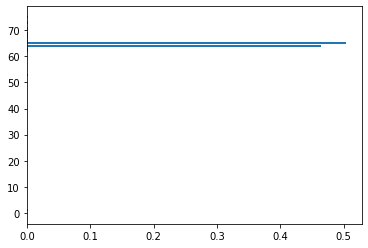

In [75]:
plt.barh(range(rfc.n_features_), rfc.feature_importances_)

In [76]:
import pickle

In [77]:
output_file = open("walk1.pickle", "wb")
pickle.dump(rfc, output_file)
output_file.close()

In [80]:
from joblib import dump, load

In [81]:
output_file = open("preprocessor.joblib", "wb")
dump(preprocessor, output_file)
output_file.close()

In [ ]:
# model_file = open('walk1.pickle', "rb")
# loaded_model = pickle.load(model_file)
# model_file.close()